In [2]:
import os
import re
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from scipy.ndimage import uniform_filter
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import tifffile as tiff

In [3]:
folder_path = '/Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/supplemental/calibration'


Average intensity for blank images: 113.51095750596788
Average intensity for 100.0%: 8076.796208500862
Average intensity for 50.0%: 3729.497436404228
Average intensity for 25.0%: 1906.4293213685353
Average intensity for 14.299999999999999%: 1087.2060511112213
Average intensity for 5.0%: 386.3007231842388
Average intensity for 1.79%: 161.24900449646844
Average intensity for 1.0%: 124.39771244923274


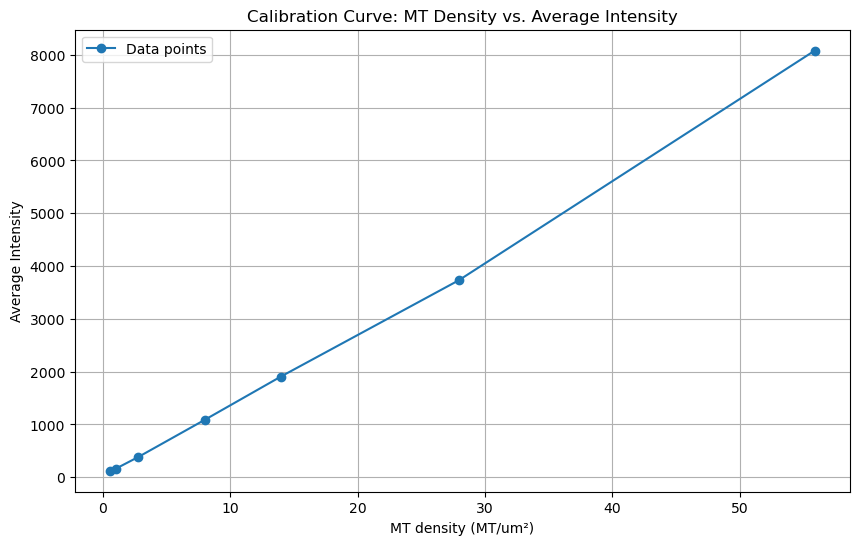

In [4]:
def load_images(folder_path):
    images = {}
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".tif") or file.endswith(".tiff"):
                concentration = os.path.basename(root)
                image_path = os.path.join(root, file)
                image = tiff.imread(image_path)
                if concentration not in images:
                    images[concentration] = []
                images[concentration].append(image)
    return images

def subtract_background(images, blank_images):
    if not blank_images:
        print("No blank images available for background subtraction.")
        return images
    
    for concentration, image_list in images.items():
        for i in range(len(image_list)):
            blank_image = blank_images[i % len(blank_images)]
            image_list[i] = image_list[i] - blank_image
    return images

def calculate_average_intensity(images):
    average_intensities = {}
    for concentration, image_list in images.items():
        if image_list:  # Check if the list is not empty
            avg_intensity = np.mean([np.mean(image) for image in image_list])
            avg_concentration = float(concentration.split('_')[0])
            if avg_concentration not in average_intensities:
                average_intensities[avg_concentration] = []
            average_intensities[avg_concentration].append(avg_intensity)
        else:
            print(f"No images found for concentration: {concentration}")
    return average_intensities

def calculate_blank_intensity(blank_images):
    if not blank_images:
        print("No blank images available to calculate blank intensity.")
        return 0
    blank_intensities = [np.mean(image) for image in blank_images]
    avg_blank_intensity = np.mean(blank_intensities)
    print(f"Average intensity for blank images: {avg_blank_intensity}")
    return avg_blank_intensity

def print_average_intensities(average_intensities):
    sorted_concentrations = sorted(average_intensities.keys(), reverse=True)
    for concentration in sorted_concentrations:
        avg_intensity = np.mean(average_intensities[concentration])
        print(f"Average intensity for {concentration*100}%: {avg_intensity}")

def convert_to_mt_per_um2(concentrations):
    conversion_factor = reference_value / reference_concentration  # 1 MT/um² per 0.0179%
    mt_per_um2 = {conc: conc * conversion_factor for conc in concentrations}
    return mt_per_um2

# Parameters
reference_concentration = 0.0179  # 0.0179% is the reference concentration
reference_value = 1.0  # MT/um²

# Folder path (you need to set this to your folder path)

# Load images
images = load_images(folder_path)

# Identify blank images
blank_keys = [key for key in images.keys() if 'blank' in key.lower()]
blank_images = []
for blank_key in blank_keys:
    blank_images.extend(images[blank_key])

images = {k: v for k, v in images.items() if k not in blank_keys}

# Subtract background
images = subtract_background(images, blank_images)

# Calculate average intensities
average_intensities = calculate_average_intensity(images)

# Calculate and print blank intensity
calculate_blank_intensity(blank_images)

# Print average intensities for each concentration
print_average_intensities(average_intensities)

# Convert concentrations to MT/um²
mt_per_um2 = convert_to_mt_per_um2(average_intensities.keys())

# Prepare data for plotting
mt_densities = [mt_per_um2[c] for c in sorted(average_intensities.keys(), reverse=True)]
intensities = [np.mean(average_intensities[c]) for c in sorted(average_intensities.keys(), reverse=True)]

# Plotting the calibration curve
plt.figure(figsize=(10, 6))
plt.plot(mt_densities, intensities, 'o-', label='Data points')
plt.xlabel('MT density (MT/um²)')
plt.ylabel('Average Intensity')
plt.title('Calibration Curve: MT Density vs. Average Intensity')
plt.legend()
plt.grid(True)
plt.show()


Calibration curve equation: Average Intensity = 143.05 * MT Density + -39.76


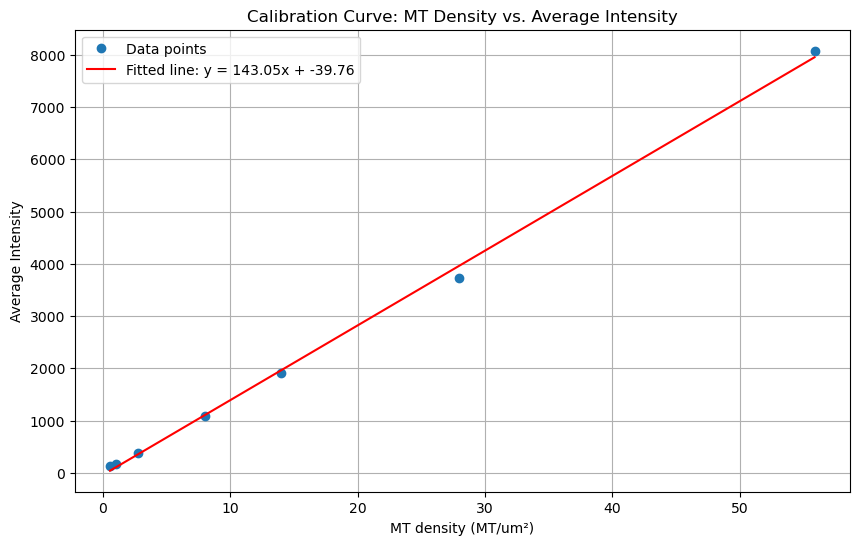

In [5]:
# Prepare the data
mt_densities = np.array(mt_densities).reshape(-1, 1)
intensities = np.array(intensities)

# Fit a linear regression model
model = LinearRegression()
model.fit(mt_densities, intensities)

# Get the slope and intercept of the fitted line
slope = model.coef_[0]
intercept = model.intercept_

# Print the equation of the line
print(f"Calibration curve equation: Average Intensity = {slope:.2f} * MT Density + {intercept:.2f}")

# Plot the data points and the fitted line
plt.figure(figsize=(10, 6))
plt.plot(mt_densities, intensities, 'o', label='Data points')
plt.plot(mt_densities, model.predict(mt_densities), 'r-', label=f'Fitted line: y = {slope:.2f}x + {intercept:.2f}')
plt.xlabel('MT density (MT/um²)')
plt.ylabel('Average Intensity')
plt.title('Calibration Curve: MT Density vs. Average Intensity')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
base_folder = '/Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104'


Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_170_min_no_6.1_1/Pos1
Overall Average Microtubule Density for Pos1: 2.28 MT/µm²
Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_170_min_no_6.1_1/Pos0
Overall Average Microtubule Density for Pos0: 2.18 MT/µm²
Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_170_min_no_6.1_1/Pos2
Overall Average Microtubule Density for Pos2: 2.23 MT/µm²
Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_65_min_no_6.1_1/Pos1
Overall Average Microtubule Density for Pos1: 2.15 MT/µm²
Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_

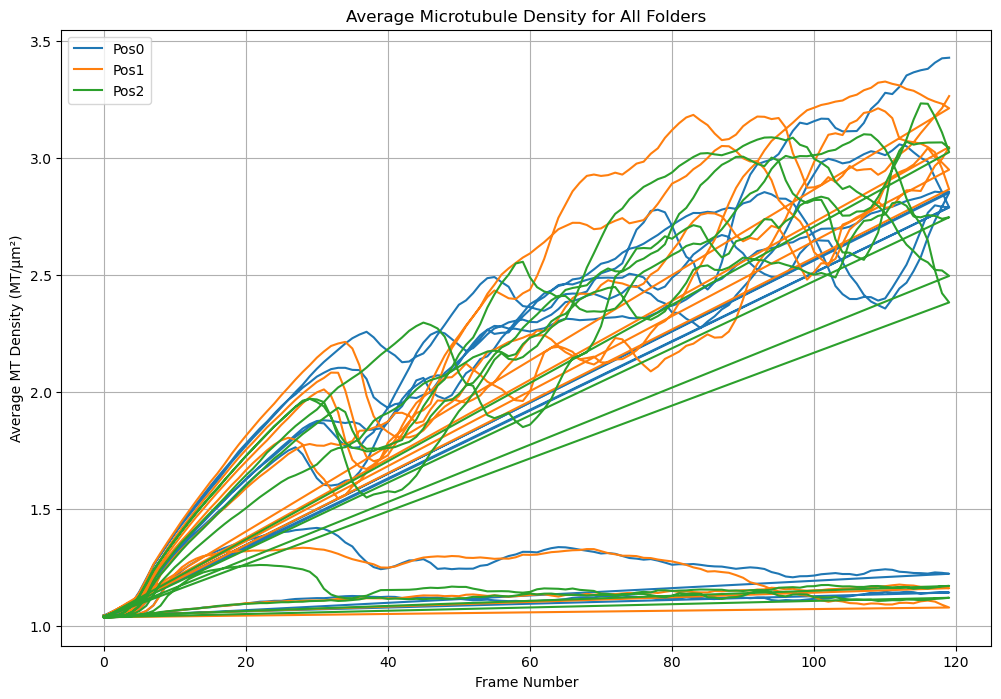

In [8]:
import os
import re
import numpy as np
import pandas as pd
from PIL import Image
from scipy.ndimage import uniform_filter
import matplotlib.pyplot as plt

# Constants
PIXEL_SIZE_UM = 0.43
CUT_LEFT_UM = 179.31
CUT_RIGHT_UM = 43
SLICE_HEIGHT_UM = 50

# Convert to pixels
cut_left_px = int(CUT_LEFT_UM / PIXEL_SIZE_UM)
cut_right_px = int(CUT_RIGHT_UM / PIXEL_SIZE_UM)
slice_height_px = int(SLICE_HEIGHT_UM / PIXEL_SIZE_UM)

def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

def calculate_microtubule_density(image_np, calibration_factor):
    return image_np * calibration_factor

def process_image_sequence(tiff_folder_path, temperature=300):
    tiff_files = sorted([f for f in os.listdir(tiff_folder_path) if 'Cy5_' in f and f.endswith('.tif')], key=natural_sort_key)
    results = []
    mt_densities = []

    first_image_path = os.path.join(tiff_folder_path, tiff_files[0])
    first_image = Image.open(first_image_path)
    first_image_np = np.array(first_image)
    first_image_np = uniform_filter(first_image_np, size=8)
    average_intensity_first_frame = np.mean(first_image_np)
    calibration_factor = 1 / average_intensity_first_frame

    for i, tiff_file in enumerate(tiff_files):
        image_path = os.path.join(tiff_folder_path, tiff_file)
        image = Image.open(image_path)
        image_np = np.array(image)
        image_np = uniform_filter(image_np, size=8)
        
        height, width = image_np.shape
        center_y = height // 2

        slice_np = image_np[center_y - slice_height_px // 2:center_y + slice_height_px // 2, cut_left_px:width - cut_right_px]
        mt_density = calculate_microtubule_density(slice_np, calibration_factor)
        
        avg_mt_density = np.mean(mt_density)
        mt_densities.append(avg_mt_density)
        
        results.append({
            'Frame': i,
            'Avg_MT_Density': avg_mt_density
        })
    
    return results, mt_densities

# Main processing function
def process_all_folders(base_folder):
    all_results = []
    
    for root, dirs, files in os.walk(base_folder):
        if any(f.endswith('.tif') for f in files):
            print(f"Processing folder: {root}")
            results, mt_densities = process_image_sequence(root)
            
            folder_name = os.path.basename(root)
            for result in results:
                result['Folder'] = folder_name
            
            all_results.extend(results)
            
            # Plot for this specific folder
            df = pd.DataFrame(results)
            plt.figure(figsize=(10, 6))
            plt.plot(df['Frame'], df['Avg_MT_Density'], marker='o')
            plt.xlabel('Frame Number')
            plt.ylabel('Average MT Density (MT/µm²)')
            plt.title(f'Average Microtubule Density for Each Frame in {folder_name}')
            plt.grid(True)
            plt.savefig(os.path.join(root, f'{folder_name}_mt_density_plot.png'))
            plt.close()
            
            # Print overall average for this folder
            overall_avg_mt_density = np.mean(mt_densities)
            print(f'Overall Average Microtubule Density for {folder_name}: {overall_avg_mt_density:.2f} MT/µm²')
    
    return pd.DataFrame(all_results)

# Specify the base folder containing all your data

# Process all folders
all_data = process_all_folders(base_folder)

# Save all data to a CSV file
all_data.to_csv(os.path.join(base_folder, 'all_microtubule_density_data.csv'), index=False)

# Plot overall results
plt.figure(figsize=(12, 8))
for folder, group in all_data.groupby('Folder'):
    plt.plot(group['Frame'], group['Avg_MT_Density'], label=folder)
plt.xlabel('Frame Number')
plt.ylabel('Average MT Density (MT/µm²)')
plt.title('Average Microtubule Density for All Folders')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(base_folder, 'overall_mt_density_plot.png'))
plt.show()

Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_170_min_no_6.1_1/Pos1
Overall Average Microtubule Density for Pos1: 2.28 MT/µm²
Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_170_min_no_6.1_1/Pos0
Overall Average Microtubule Density for Pos0: 2.18 MT/µm²
Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_170_min_no_6.1_1/Pos2
Overall Average Microtubule Density for Pos2: 2.23 MT/µm²
Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_65_min_no_6.1_1/Pos1
Overall Average Microtubule Density for Pos1: 2.15 MT/µm²
Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_

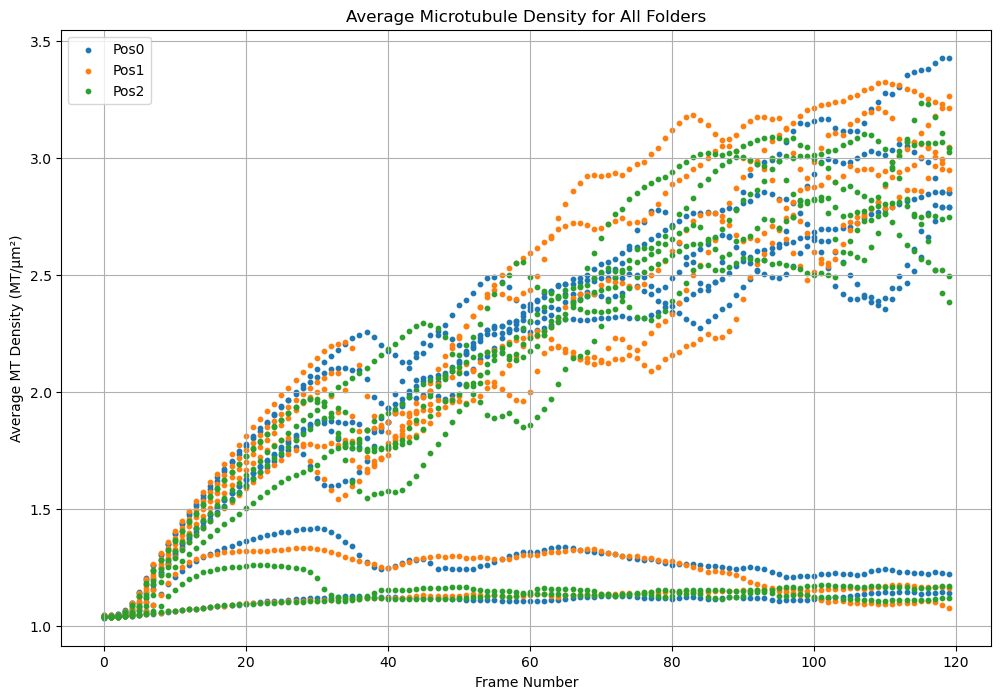


Overall Statistics:
        count      mean       std       min       25%       50%       75%  \
Folder                                                                      
Pos0    840.0  1.916796  0.652840  1.036051  1.248203  1.950642  2.455758   
Pos1    840.0  1.941621  0.713538  1.037192  1.250700  1.868905  2.590447   
Pos2    840.0  1.893658  0.686369  1.035183  1.154974  1.845861  2.531255   

             max  
Folder            
Pos0    3.429887  
Pos1    3.327992  
Pos2    3.234567  


In [11]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from scipy.ndimage import uniform_filter
import matplotlib.pyplot as plt

# Constants
PIXEL_SIZE_UM = 0.43
CUT_LEFT_UM = 179.31
CUT_RIGHT_UM = 43
SLICE_HEIGHT_UM = 50

# Convert to pixels
cut_left_px = int(CUT_LEFT_UM / PIXEL_SIZE_UM)
cut_right_px = int(CUT_RIGHT_UM / PIXEL_SIZE_UM)
slice_height_px = int(SLICE_HEIGHT_UM / PIXEL_SIZE_UM)

def calculate_microtubule_density(image_np, calibration_factor):
    return image_np * calibration_factor

def process_image_sequence(tiff_folder_path, temperature=300):
    tiff_files = sorted([f for f in os.listdir(tiff_folder_path) if 'Cy5_' in f and f.endswith('.tif')])
    results = []
    mt_densities = []

    first_image_path = os.path.join(tiff_folder_path, tiff_files[0])
    first_image = Image.open(first_image_path)
    first_image_np = np.array(first_image)
    first_image_np = uniform_filter(first_image_np, size=8)
    average_intensity_first_frame = np.mean(first_image_np)
    calibration_factor = 1 / average_intensity_first_frame

    for i, tiff_file in enumerate(tiff_files):
        image_path = os.path.join(tiff_folder_path, tiff_file)
        image = Image.open(image_path)
        image_np = np.array(image)
        image_np = uniform_filter(image_np, size=8)
        
        height, width = image_np.shape
        center_y = height // 2

        slice_np = image_np[center_y - slice_height_px // 2:center_y + slice_height_px // 2, cut_left_px:width - cut_right_px]
        mt_density = calculate_microtubule_density(slice_np, calibration_factor)
        
        avg_mt_density = np.mean(mt_density)
        mt_densities.append(avg_mt_density)
        
        results.append({
            'Frame': i,
            'Avg_MT_Density': avg_mt_density
        })
    
    return results, mt_densities

def process_all_folders(base_folder):
    all_results = []
    
    for root, dirs, files in os.walk(base_folder):
        if any(f.endswith('.tif') for f in files):
            print(f"Processing folder: {root}")
            results, mt_densities = process_image_sequence(root)
            
            folder_name = os.path.basename(root)
            for result in results:
                result['Folder'] = folder_name
            
            all_results.extend(results)
            
            # Print overall average for this folder
            overall_avg_mt_density = np.mean(mt_densities)
            print(f'Overall Average Microtubule Density for {folder_name}: {overall_avg_mt_density:.2f} MT/µm²')
    
    return pd.DataFrame(all_results)

# Specify the base folder containing all your data

# Process all folders
all_data = process_all_folders(base_folder)

# Save all data to a CSV file
all_data.to_csv(os.path.join(base_folder, 'all_microtubule_density_data.csv'), index=False)


# Plot overall results
plt.figure(figsize=(12, 8))
for folder, group in all_data.groupby('Folder'):
    plt.scatter(group['Frame'], group['Avg_MT_Density'], label=folder, s=10)  # s=10 sets the marker size
plt.xlabel('Frame Number')
plt.ylabel('Average MT Density (MT/µm²)')
plt.title('Average Microtubule Density for All Folders')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(base_folder, 'overall_mt_density_plot.png'))
plt.show()


# Print overall statistics
print("\nOverall Statistics:")
print(all_data.groupby('Folder')['Avg_MT_Density'].describe())

Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_170_min_no_6.1_1/Pos1
Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_170_min_no_6.1_1/Pos0
Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_170_min_no_6.1_1/Pos2
Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_65_min_no_6.1_1/Pos1
Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_65_min_no_6.1_1/Pos0
Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_65_min_no_6.1_1/Pos2
Processing folder: /Users/scliu

/var/folders/p3/mdh493ks43l04slykq6gwbx80000gn/T/ipykernel_80641/1161625288.py:101: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


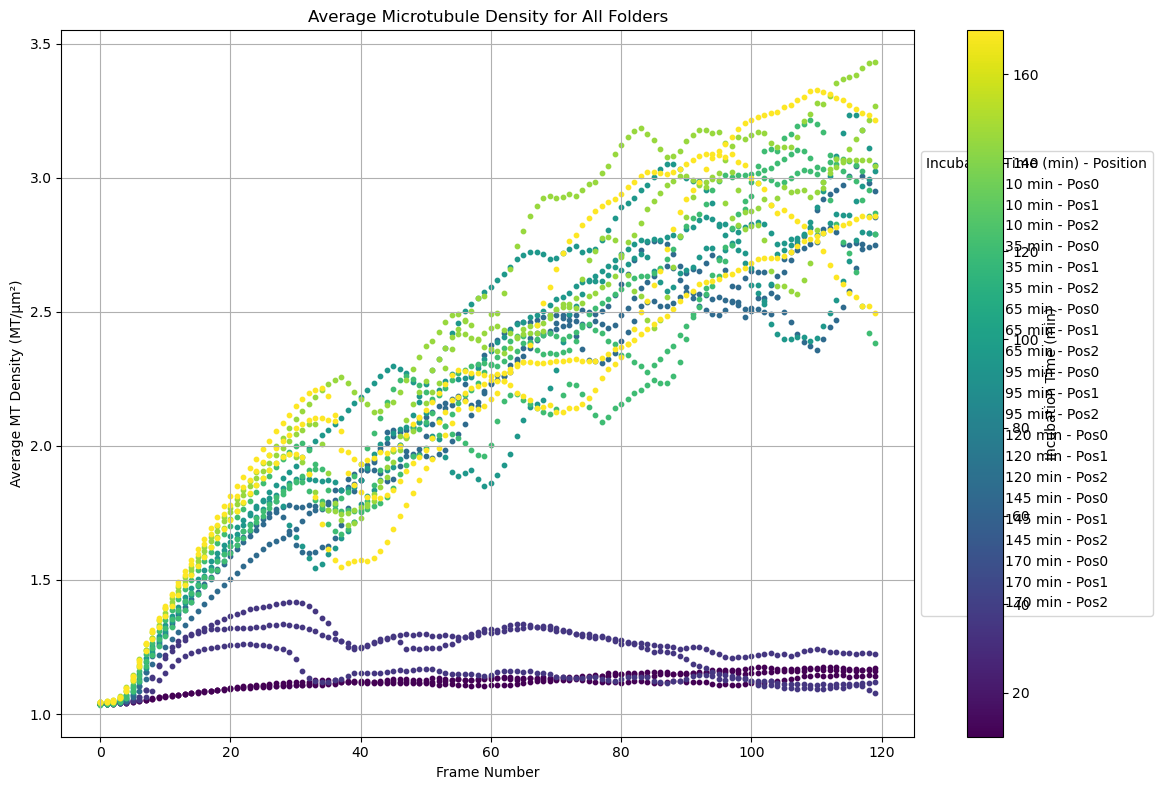


Overall Statistics:
                          count      mean       std       min       25%  \
Incubation Time Position                                                  
10              Pos0      120.0  1.110848  0.025084  1.036051  1.107476   
                Pos1      120.0  1.125329  0.034282  1.037192  1.108860   
                Pos2      120.0  1.125395  0.035663  1.036948  1.106740   
35              Pos0      120.0  1.266267  0.081559  1.037388  1.229636   
                Pos1      120.0  1.231163  0.093897  1.038981  1.132797   
                Pos2      120.0  1.147303  0.050512  1.037202  1.122073   
65              Pos0      120.0  2.102878  0.502033  1.040305  1.675686   
                Pos1      120.0  2.148399  0.555687  1.037701  1.771441   
                Pos2      120.0  2.095373  0.514877  1.040174  1.686005   
95              Pos0      120.0  2.181157  0.529197  1.042363  1.842997   
                Pos1      120.0  2.266666  0.625164  1.041560  1.692752   
    

In [14]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from scipy.ndimage import uniform_filter
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# Constants
PIXEL_SIZE_UM = 0.43
CUT_LEFT_UM = 179.31
CUT_RIGHT_UM = 43
SLICE_HEIGHT_UM = 50

# Convert to pixels
cut_left_px = int(CUT_LEFT_UM / PIXEL_SIZE_UM)
cut_right_px = int(CUT_RIGHT_UM / PIXEL_SIZE_UM)
slice_height_px = int(SLICE_HEIGHT_UM / PIXEL_SIZE_UM)

def calculate_microtubule_density(image_np, calibration_factor):
    return image_np * calibration_factor

def process_image_sequence(tiff_folder_path):
    tiff_files = sorted([f for f in os.listdir(tiff_folder_path) if 'Cy5_' in f and f.endswith('.tif')])
    results = []
    
    first_image_path = os.path.join(tiff_folder_path, tiff_files[0])
    first_image = Image.open(first_image_path)
    first_image_np = np.array(first_image)
    first_image_np = uniform_filter(first_image_np, size=8)
    average_intensity_first_frame = np.mean(first_image_np)
    calibration_factor = 1 / average_intensity_first_frame

    for i, tiff_file in enumerate(tiff_files):
        image_path = os.path.join(tiff_folder_path, tiff_file)
        image = Image.open(image_path)
        image_np = np.array(image)
        image_np = uniform_filter(image_np, size=8)
        
        height, width = image_np.shape
        center_y = height // 2

        slice_np = image_np[center_y - slice_height_px // 2:center_y + slice_height_px // 2, cut_left_px:width - cut_right_px]
        mt_density = calculate_microtubule_density(slice_np, calibration_factor)
        
        avg_mt_density = np.mean(mt_density)
        results.append({
            'Frame': i,
            'Avg_MT_Density': avg_mt_density
        })
    
    return results

def extract_incubation_time(folder_name):
    incubation_time_str = folder_name.split('_')[1]
    return int(incubation_time_str.split('_')[0])


# Process all folders
all_data = []
experiment_folders = [f for f in os.listdir(base_folder) if 'correlation' in f]

for exp_folder in experiment_folders:
    incubation_time = extract_incubation_time(exp_folder)
    exp_folder_path = os.path.join(base_folder, exp_folder)
    pos_folders = [os.path.join(exp_folder_path, d) for d in os.listdir(exp_folder_path) if d.startswith('Pos')]

    for pos_folder in pos_folders:
        print(f"Processing folder: {pos_folder}")
        results = process_image_sequence(pos_folder)
        
        for result in results:
            result['Incubation Time'] = incubation_time
            result['Position'] = os.path.basename(pos_folder)
        
        all_data.extend(results)

# Convert to DataFrame
df = pd.DataFrame(all_data)

# Plotting
incubation_times = sorted(df['Incubation Time'].unique())
norm = Normalize(vmin=min(incubation_times), vmax=max(incubation_times))
cmap = plt.get_cmap('viridis')

plt.figure(figsize=(12, 8))

for (incubation_time, position), group in df.groupby(['Incubation Time', 'Position']):
    color = cmap(norm(incubation_time))
    plt.scatter(group['Frame'], group['Avg_MT_Density'], 
                c=[color], s=10, label=f"{incubation_time} min - {position}")

plt.xlabel('Frame Number')
plt.ylabel('Average MT Density (MT/µm²)')
plt.title('Average Microtubule Density for All Folders')
plt.grid(True)

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Incubation Time (min)')

# Legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title="Incubation Time (min) - Position", 
           loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig(os.path.join(base_folder, 'microtubule_density_all_folders.png'), bbox_inches='tight')
plt.show()

# Print overall statistics
print("\nOverall Statistics:")
print(df.groupby(['Incubation Time', 'Position'])['Avg_MT_Density'].describe())